# North Carolina School of Science and Math Data Prep

In [1]:
import os
import subprocess
import sys
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from pprint import pprint
from PIL import Image 
import pandas as pd
import sqlite3


# Ask GRASS GIS where its Python packages are.
gisbase = subprocess.check_output(["grass", "--config", "path"], text=True).strip()
os.environ["GISBASE"] = gisbase
print(gisbase)

# Ask GRASS GIS where its Python packages are.
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)

# Import the GRASS GIS packages we need.
import grass.script as gs

# Import GRASS Jupyter
import grass.jupyter as gj


# Start GRASS Session
## Set your grass data location
gj.init("./grassdata/nc_basic_spm_grass7/ncssm")

/usr/local/grass83


## Import NC QL2 3m DEM

In [388]:
gs.run_command("g.region", res=3, flags="p")
gs.run_command("r.import", 
               input="./data/DurhamCoNC_elevation_97785/DurhamCoNC/Rasters/QL2/DEM03/D03_37_20082201_20160228.img",
               output="ncssm_ql2_3m",
               resample="bicubic",
               resolution="value",
               resolution_value=3,
               title="NC QL2 3m DEM")

# Set color table
gs.run_command("r.colors", map="ncssm_ql2_3m", color="elevation")

## Set Computational Region

In [ ]:
gs.run_command("g.region", raster="ncssm_ql2_3m", res=3, flags="p")

## Import Vector Data from North Carolina Online Data Portals

* [NC OneMap](https://www.nconemap.gov/)
* [Durham OpenData Portal](https://live-durhamnc.opendata.arcgis.com/)

### North Carolina School of Science and Math Boundary

In [ ]:
ncssm = "https://services2.arcgis.com/G5vR3cOjh6g2Ed8E/arcgis/rest/services/Parcels/FeatureServer/0/query?outFields=*&where=OBJECTID%3D5653314&f=geojson"

gs.run_command("v.import",
            input=ncssm,
            layer="OGRGeoJSON",
            extent="input",
            output="ncssm",
            overwrite=True
)

### Durham Roads

In [408]:
roads = "https://webgis2.durhamnc.gov/server/rest/services/PublicServices/Transportation/MapServer/6/query?outFields=*&where=1%3D1&f=geojson"

gs.run_command("v.import",
            input=roads,
            layer="OGRGeoJSON",
            extent="region",
            output="roads",
            overwrite=True
)

### Durham Greenways

In [410]:
greenways = "https://webgis2.durhamnc.gov/server/rest/services/ProjectServices/Trans_ExistingFutureBikePedFacilities/MapServer/1/query?outFields=*&where=1%3D1&f=geojson"
gs.run_command("v.import",
            input=greenways,
            layer="OGRGeoJSON",
            extent="region",
            output="greenways",
            overwrite=True
)

### Durham Sidewalks

In [411]:
sidewalks = "https://webgis2.durhamnc.gov/server/rest/services/PublicServices/Community/MapServer/5/query?outFields=*&where=1%3D1&f=geojson"
gs.run_command("v.import",
            input=sidewalks,
            layer="OGRGeoJSON",
            extent="region",
            output="sidewalks",
            overwrite=True
)

### Open Channels

In [415]:
open_channels = "https://webgis2.durhamnc.gov/server/rest/services/PublicWorksServices/StormwaterUtilitiesMapService/MapServer/4/query?outFields=*&where=1%3D1&f=geojson"
gs.run_command("v.import",
            input=open_channels,
            layer="OGRGeoJSON",
            extent="region",
            output="open_channels",
            overwrite=True
)

### Display imported data

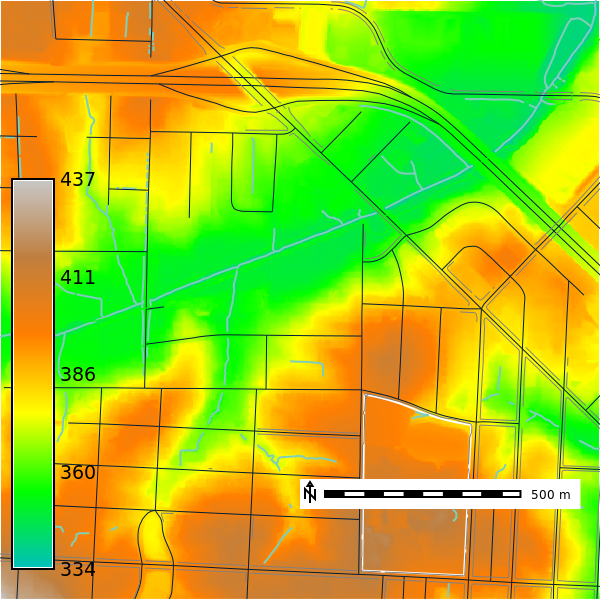

In [418]:
map = gj.Map()
map.d_rast(map="ncssm_ql2_3m")
map.d_vect(map="ncssm", fill_color="none", color="white", width=2)
map.d_vect(map="open_channels", color="#7fcdbb", width=2)
map.d_vect(map="roads")
map.d_vect(map="greenways", color="green")
map.d_vect(map="sidewalks", color="grey")
map.d_legend(raster="ncssm_ql2_3m", at=(5,70,2,9))
map.d_barscale(at=(50,20,1,2), flags="n")
map.show()

## Import Lidar Data

### Bare Earth Points

In [396]:
gs.run_command("v.in.pdal",
               input="./data/175003_1.las",
               output="ncssm_lidar_be_pts",
               flags="w",
               class_filter="2,13",
               overwrite=True
        )

#### Interpolate 1m DTM

In [397]:
gs.run_command("g.region", raster="ncssm_ql2_3m", res=1, flags="ap")
gs.run_command("v.surf.rst", 
               input="ncssm_lidar_be_pts", 
               elevation="ncssm_be_1m",
               mask="ncssm_ql2_3m",
               tension=10,
               smooth=0.5,
               nprocs=25,
               overwrite=True
              )

gs.run_command("r.colors", map="ncssm_be_1m", color="elevation")

projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      252984
south:      251460
west:       615696
east:       617223
nsres:      1
ewres:      1
rows:       1524
cols:       1527
cells:      2327148


#### 3D Map

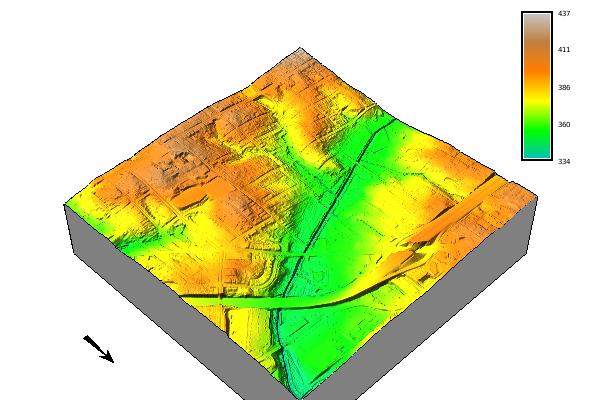

In [398]:
elevation_3dmap = gj.Map3D()
# Full list of options m.nviz.image
# https://grass.osgeo.org/grass83/manuals/m.nviz.image.html
elevation_3dmap.render(
    elevation_map="ncssm_be_1m",
    color_map="ncssm_be_1m",
    perspective=20,
    height=4000,
    resolution_fine=1,
    fringe=['ne','nw','sw','se'],
    arrow_position=[100,50],
)
elevation_3dmap.overlay.d_legend(raster="ncssm_ql2_3m", at=(60, 97, 87, 92))
elevation_3dmap.show()

### All Points

In [399]:
gs.run_command("v.in.pdal",
               input="./data/175003_1.las",
               output="ncssm_lidar_pts",
               flags="w",
               overwrite=True
        )

#### Remove outliers

In [400]:
gs.run_command("v.outlier", input="ncssm_lidar_pts", output="ncssm_lidar_pts_clean", outlier="ncssm_lidar_pts_pts_outliers", threshold=25)

#### Interpolate 1m DSM

In [401]:
gs.run_command("v.surf.rst", 
               input="ncssm_lidar_pts_clean", 
               elevation="ncssm_1m",
               mask="ncssm_ql2_3m",
               tension=40,
               smooth=0.5,
               nprocs=25,
               overwrite=True
              )

# Change color table
gs.run_command("r.colors", map="ncssm_1m", color="elevation")

#### 3D Map

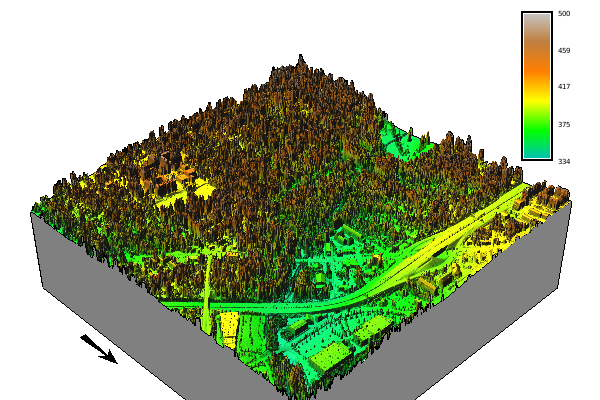

In [402]:
elevation_3dmap = gj.Map3D(use_region=False)
# Full list of options m.nviz.image
# https://grass.osgeo.org/grass83/manuals/m.nviz.image.html
elevation_3dmap.render(
    elevation_map="ncssm_1m",
    color_map="ncssm_1m",
    perspective=20,
    height=3000,
    resolution_fine=1,
    zexag=1,
    fringe=['ne','nw','sw','se'],
    fringe_elevation=10,
    arrow_position=[100,50],
)
elevation_3dmap.overlay.d_legend(raster="ncssm_1m", at=(60, 97, 87, 92))
elevation_3dmap.show()

## NAIP 2022 Data

In [391]:
gs.run_command("t.stac.import",
               url="https://planetarycomputer.microsoft.com/api/stac/v1",
               request_method="POST", 
               collections="naip",
               datetime=2022,
               asset_keys="image",
               extent="region",
               nprocs=1,
               memory=300)

In [419]:
!g.list type=raster

basins
elevation
elevation_shade
geology
lakes
landuse
naip2022.blue
naip2022.green
naip2022.nir
naip2022.red
naip_2022_rgb
ncssm_1m
ncssm_be_1m
ncssm_ql2_3m
soils


#### Rename the NAIP data

In [ ]:
%%bash
# Rename data
g.rename raster=nc_m_3607857_se_17_060_20220914.m_3607857_se_17_060_20220914.1,naip2022.blue
g.rename raster=nc_m_3607857_se_17_060_20220914.m_3607857_se_17_060_20220914.2,naip2022.green
g.rename raster=nc_m_3607857_se_17_060_20220914.m_3607857_se_17_060_20220914.3,naip2022.red
g.rename raster=nc_m_3607857_se_17_060_20220914.m_3607857_se_17_060_20220914.4,naip2022.nir

# Create composite
r.composite blue=naip2022.blue green=naip2022.green red=naip2022.red output=naip_2022_rgb

### Map

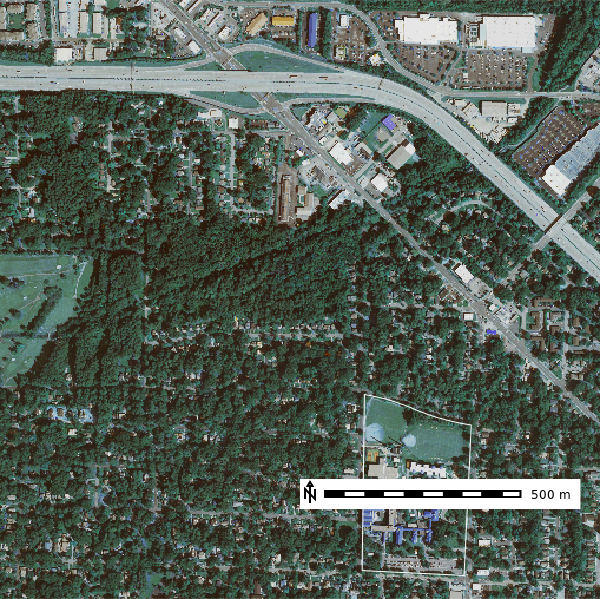

In [405]:
map = gj.Map()
map.d_rast(map="naip_2022_rgb")
map.d_vect(map="ncssm", fill_color="none", color="white")
map.d_barscale(at=(50,20,1,2), flags="n")
map.show()

### 3D Map

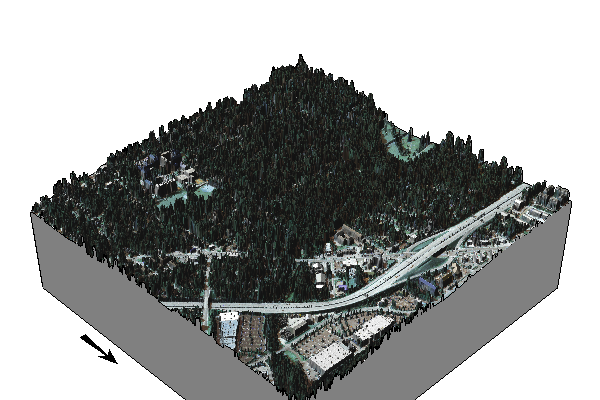

In [407]:
elevation_3dmap = gj.Map3D(use_region=False)
# Full list of options m.nviz.image
# https://grass.osgeo.org/grass83/manuals/m.nviz.image.html
elevation_3dmap.render(
    elevation_map="ncssm_1m",
    color_map="naip_2022_rgb",
    perspective=20,
    height=3000,
    resolution_fine=1,
    zexag=1,
    fringe=['ne','nw','sw','se'],
    fringe_elevation=10,
    arrow_position=[100,50],
)
elevation_3dmap.show()

## Import NCLD data

[Data download](https://www.mrlc.gov/data?f%5B0%5D=category%3ALand%20Cover&f%5B1%5D=region%3Aconus&f%5B2%5D=year%3A2021) and import into your project.

### Add Category Labels

In [10]:
nlcd_list = gs.read_command(
    "g.list", type="raster", pattern="nlcd*", separator="comma"
).strip()

In [20]:
for nlcd in nlcd_list.split(","):
    gs.run_command("r.category", map=nlcd, separator=":", rules="./grass_conf/nlcd_classes.txt")

gs.run_command("r.category", map="nlcd_2019")

21	Developed (Open Space)
22	Developed (Low Intensity)
23	Developed (Medium Intensity)
24	Developed (High Intensity)
31	Barren Land
41	Deciduous Forest
42	Evergreen Forest
43	Mixed Forest


### Create STRDS

In [24]:
gs.run_command(
    "t.create",
    output="nlcd",
    type="strds",
    temporaltype="absolute",
    title="National Land Cover Dataset 2001 - 2019",
    description="National Land Cover Dataset"
)

gs.run_command(
    "t.register",
    input="nlcd",
    type="raster",
    file="./grass_conf/nlcd_register.txt"
)

### Display Data

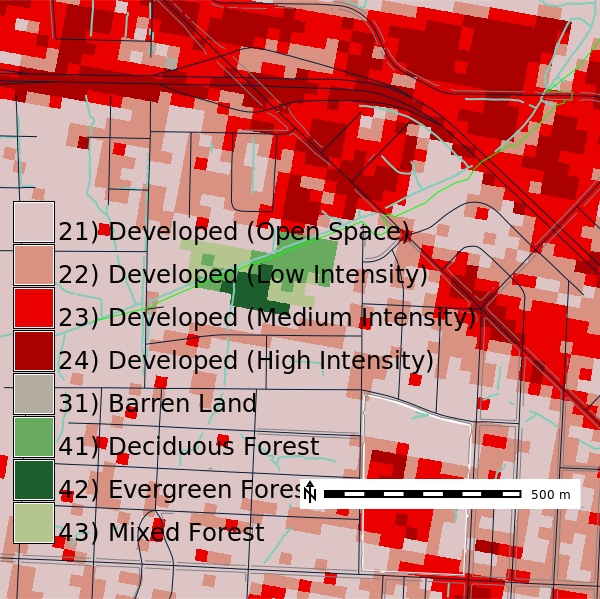

In [27]:
map = gj.Map()
map.d_rast(map="nlcd_2019")
map.d_vect(map="ncssm", fill_color="none", color="white", width=2)
map.d_vect(map="open_channels", color="#7fcdbb", width=2)
map.d_vect(map="roads")
map.d_vect(map="greenways", color="green")
map.d_vect(map="sidewalks", color="grey")
map.d_legend(raster="nlcd_2019", at=(5,70,2,9), flags="n")
map.d_barscale(at=(50,20,1,2), flags="n")
map.show()

### Create Time Series Slider

In [25]:
nlcd_ts_map = gj.TimeSeriesMap(height=1000, width=1000, use_region=True)
nlcd_ts_map.add_raster_series("nlcd")
nlcd_ts_map.d_legend()
nlcd_ts_map.render()
nlcd_ts_map.save("output/nlcd.gif")
nlcd_ts_map.show()